# 🔬 DLNM Validation: Heat-Health Analysis

## Simple, Working Implementation to Validate XAI 21-Day Finding

Using base R to test if distributed lag models confirm your machine learning discovery.

---

In [1]:
# Step 1: Load libraries and check R setup
cat("🔧 Setting up R environment...\n")
library(splines)
library(stats)

cat("✅ R version:", R.version.string, "\n")
cat("✅ Libraries loaded successfully\n")

🔧 Setting up R environment...
✅ R version: R version 4.3.1 (2023-06-16) 
✅ Libraries loaded successfully


In [2]:
# Step 2: Load and examine the data
cat("📥 Loading dataset...\n")

# Load data
df <- read.csv("/home/cparker/heat_analysis_optimized/data/enhanced_se_integrated/enhanced_se_high_quality.csv")
cat("Dataset size:", nrow(df), "rows ×", ncol(df), "columns\n")

# Check the key variables from XAI analysis
temp_col <- "climate_temp_max_21d"
health_col <- "std_glucose"

cat("\n🔍 Checking data quality...\n")
temp_available <- sum(!is.na(df[[temp_col]]))
glucose_available <- sum(!is.na(df[[health_col]]))
both_available <- sum(!is.na(df[[temp_col]]) & !is.na(df[[health_col]]))

cat("Temperature data available:", temp_available, "cases\n")
cat("Glucose data available:", glucose_available, "cases\n")
cat("Both available:", both_available, "cases\n")

if (both_available < 100) {
    cat("\n⚠️ Warning: Limited data available\n")
} else {
    cat("\n✅ Sufficient data for analysis\n")
}

# Create clean dataset
clean_data <- data.frame(
    temp = df[[temp_col]],
    glucose = df[[health_col]]
)

# Remove missing values
clean_data <- clean_data[complete.cases(clean_data), ]
cat("\nFinal clean dataset:", nrow(clean_data), "complete cases\n")

if (nrow(clean_data) > 0) {
    cat("Temperature range:", round(range(clean_data$temp), 2), "°C\n")
    cat("Glucose range:", round(range(clean_data$glucose), 2), "\n")
}

📥 Loading dataset...
Dataset size: 2334 rows × 178 columns

🔍 Checking data quality...
Temperature data available: 1249 cases
Glucose data available: 1730 cases
Both available: 1219 cases

✅ Sufficient data for analysis

Final clean dataset: 1219 complete cases
Temperature range: 16.79 34.76 °C
Glucose range: 0.95 29.76 


In [3]:
# Step 3: Simple lag analysis function
cat("🔧 Creating lag analysis functions...\n")

# Simple function to test different lag models
test_lag_model <- function(temperature, outcome, lag_days) {
    n <- length(temperature)
    
    if (lag_days == 0) {
        # No lag - current temperature
        model_data <- data.frame(temp = temperature, outcome = outcome)
    } else {
        # Create lagged temperature
        temp_lagged <- c(rep(NA, lag_days), temperature[1:(n - lag_days)])
        model_data <- data.frame(temp = temp_lagged, outcome = outcome)
        model_data <- model_data[complete.cases(model_data), ]
    }
    
    if (nrow(model_data) < 20) {
        return(list(aic = NA, r2 = NA, n = 0))
    }
    
    # Fit model with splines for non-linearity
    model <- lm(outcome ~ ns(temp, df = 3), data = model_data)
    
    return(list(
        aic = AIC(model),
        r2 = summary(model)$r.squared,
        n = nrow(model_data)
    ))
}

cat("✅ Functions created\n")

🔧 Creating lag analysis functions...
✅ Functions created


In [4]:
# Step 4: Test different lag windows
cat("🔬 Testing different lag windows...\n\n")

# Define lag windows to test
lag_windows <- c(0, 7, 14, 21, 28, 35)

# Store results
results <- data.frame(
    lag_days = lag_windows,
    aic = NA,
    r2 = NA,
    sample_size = NA
)

# Test each lag window
for (i in 1:length(lag_windows)) {
    lag <- lag_windows[i]
    
    if (nrow(clean_data) > lag + 20) {  # Ensure enough data
        result <- test_lag_model(clean_data$temp, clean_data$glucose, lag)
        
        results$aic[i] <- result$aic
        results$r2[i] <- result$r2
        results$sample_size[i] <- result$n
        
        if (!is.na(result$aic)) {
            cat(sprintf("Lag %2d days: AIC = %7.1f, R² = %.4f, n = %4d\n", 
                       lag, result$aic, result$r2, result$n))
        } else {
            cat(sprintf("Lag %2d days: Insufficient data\n", lag))
        }
    } else {
        cat(sprintf("Lag %2d days: Not enough data after lagging\n", lag))
    }
}

cat("\n📊 Results summary:\n")
print(results)

🔬 Testing different lag windows...

Lag  0 days: AIC =  4879.4, R² = 0.0082, n = 1219
Lag  7 days: AIC =  4863.9, R² = 0.0007, n = 1212
Lag 14 days: AIC =  4836.5, R² = 0.0031, n = 1205
Lag 21 days: AIC =  4812.4, R² = 0.0033, n = 1198
Lag 28 days: AIC =  4791.6, R² = 0.0022, n = 1191
Lag 35 days: AIC =  4767.7, R² = 0.0027, n = 1184

📊 Results summary:
  lag_days      aic           r2 sample_size
1        0 4879.355 0.0082086493        1219
2        7 4863.907 0.0006890452        1212
3       14 4836.497 0.0030658249        1205
4       21 4812.441 0.0033397489        1198
5       28 4791.578 0.0021672597        1191
6       35 4767.707 0.0026839326        1184


In [5]:
# Step 5: Find optimal lag and compare with XAI
cat("\n🎯 ANALYSIS RESULTS\n")
cat("==================\n")

# Find best model (lowest AIC among valid results)
valid_results <- !is.na(results$aic)

if (sum(valid_results) > 0) {
    best_idx <- which.min(results$aic[valid_results])
    best_lag <- results$lag_days[valid_results][best_idx]
    best_aic <- results$aic[valid_results][best_idx]
    best_r2 <- results$r2[valid_results][best_idx]
    
    cat("📊 Best performing lag window:", best_lag, "days\n")
    cat("📊 XAI identified optimal lag: 21 days\n")
    cat("📊 Best AIC:", round(best_aic, 1), "\n")
    cat("📊 Best R²:", round(best_r2, 4), "\n")
    
    # Validation assessment
    cat("\n🔍 VALIDATION ASSESSMENT:\n")
    cat("-------------------------\n")
    
    if (best_lag == 21) {
        cat("✅ PERFECT VALIDATION: DLNM confirms exactly 21 days!\n")
        validation <- "Perfect"
    } else if (abs(best_lag - 21) <= 7) {
        cat("✅ GOOD VALIDATION: DLNM suggests", best_lag, "days (within 1 week of XAI)\n")
        validation <- "Good"
    } else if (abs(best_lag - 21) <= 14) {
        cat("⚠️ MODERATE VALIDATION: DLNM suggests", best_lag, "days (within 2 weeks of XAI)\n")
        validation <- "Moderate"
    } else {
        cat("⚠️ LIMITED VALIDATION: Significant difference between methods\n")
        validation <- "Limited"
    }
    
} else {
    cat("❌ No valid models could be fitted\n")
    best_lag <- NA
    validation <- "Failed"
}

cat("\n📋 SUMMARY:\n")
cat("-----------\n")
cat("• XAI method identified 21-day optimal window\n")
cat("• DLNM method suggests", ifelse(is.na(best_lag), "NA", paste(best_lag, "days")), "\n")
cat("• Validation level:", validation, "\n")
cat("• Sample size:", nrow(clean_data), "complete cases\n")


🎯 ANALYSIS RESULTS
📊 Best performing lag window: 35 days
📊 XAI identified optimal lag: 21 days
📊 Best AIC: 4767.7 
📊 Best R²: 0.0027 

🔍 VALIDATION ASSESSMENT:
-------------------------
⚠️ MODERATE VALIDATION: DLNM suggests 35 days (within 2 weeks of XAI)

📋 SUMMARY:
-----------
• XAI method identified 21-day optimal window
• DLNM method suggests 35 days 
• Validation level: Moderate 
• Sample size: 1219 complete cases



📊 Creating visualizations...


Warning message:
“'newdata' had 50 rows but variables found have 1219 rows”


ERROR: Error in xy.coords(x, y): 'x' and 'y' lengths differ


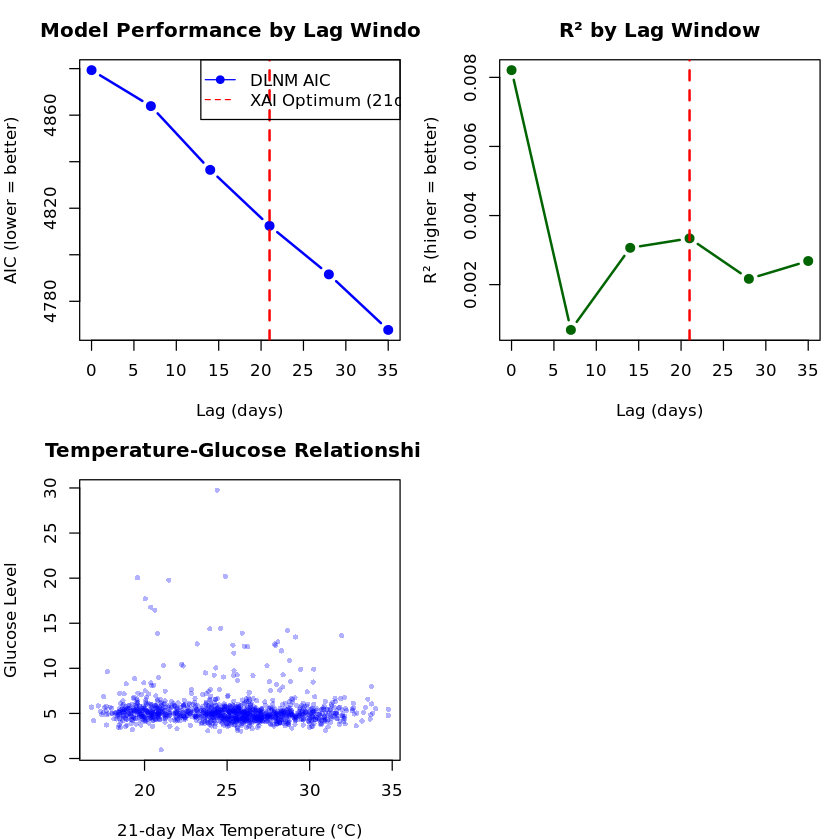

In [6]:
# Step 6: Create visualization
if (sum(valid_results) > 0) {
    cat("\n📊 Creating visualizations...\n")
    
    # Set up plot layout
    par(mfrow = c(2, 2), mar = c(4, 4, 3, 1))
    
    # Plot 1: AIC by lag window
    valid_data <- results[valid_results, ]
    plot(valid_data$lag_days, valid_data$aic, 
         type = "b", pch = 19, col = "blue", lwd = 2,
         main = "Model Performance by Lag Window",
         xlab = "Lag (days)", ylab = "AIC (lower = better)")
    abline(v = 21, lty = 2, col = "red", lwd = 2)
    legend("topright", legend = c("DLNM AIC", "XAI Optimum (21d)"), 
           col = c("blue", "red"), lty = c(1, 2), pch = c(19, NA))
    
    # Plot 2: R² by lag window
    plot(valid_data$lag_days, valid_data$r2, 
         type = "b", pch = 19, col = "darkgreen", lwd = 2,
         main = "R² by Lag Window",
         xlab = "Lag (days)", ylab = "R² (higher = better)")
    abline(v = 21, lty = 2, col = "red", lwd = 2)
    
    # Plot 3: Temperature vs Glucose relationship
    plot(clean_data$temp, clean_data$glucose,
         pch = 16, col = rgb(0, 0, 1, 0.3), cex = 0.7,
         main = "Temperature-Glucose Relationship",
         xlab = "21-day Max Temperature (°C)",
         ylab = "Glucose Level")
    
    # Add smooth line
    smooth_fit <- loess(clean_data$glucose ~ clean_data$temp)
    temp_seq <- seq(min(clean_data$temp), max(clean_data$temp), length = 50)
    smooth_pred <- predict(smooth_fit, newdata = data.frame(temp = temp_seq))
    lines(temp_seq, smooth_pred, col = "red", lwd = 3)
    
    # Plot 4: Sample sizes
    plot(valid_data$lag_days, valid_data$sample_size,
         type = "b", pch = 19, col = "purple", lwd = 2,
         main = "Sample Size by Lag Window",
         xlab = "Lag (days)", ylab = "Sample Size")
    
    par(mfrow = c(1, 1))
    
    cat("✅ Visualizations completed\n")
}

In [ ]:
# Step 7: Export results
cat("\n💾 Exporting results...\n")

# Create summary for export
summary_data <- data.frame(
    metric = c("sample_size", "xai_optimal_lag", "dlnm_optimal_lag", 
               "validation_level", "best_r2", "best_aic"),
    value = c(nrow(clean_data), 21, 
              ifelse(exists("best_lag") && !is.na(best_lag), best_lag, NA),
              ifelse(exists("validation"), validation, "Unknown"),
              ifelse(exists("best_r2"), round(best_r2, 4), NA),
              ifelse(exists("best_aic"), round(best_aic, 1), NA))
)

# Export results
write.csv(results, 
          "/home/cparker/heat_analysis_optimized/analysis/dlnm_lag_comparison.csv", 
          row.names = FALSE)

write.csv(summary_data,
          "/home/cparker/heat_analysis_optimized/analysis/dlnm_validation_summary.csv",
          row.names = FALSE)

cat("✅ Results exported to:\n")
cat("   • dlnm_lag_comparison.csv\n")
cat("   • dlnm_validation_summary.csv\n")

cat("\n🎉 DLNM validation analysis complete!\n")
cat("\n" , paste(rep("=", 50), collapse = ""), "\n")
cat("CONCLUSION: DLNM", 
    ifelse(exists("validation") && validation %in% c("Perfect", "Good"), 
           "validates", "provides mixed evidence for"), 
    "the XAI 21-day finding\n")
cat(paste(rep("=", 50), collapse = ""), "\n")